# Background

Author: Diane Menuz  
Date: June 6, 2025  
Data: Hourly and daily energy closure OLS and monthly and growing season energy closure ratios

# Parameters and Libraries

## Parameters

In [1]:
stationid = 'US-CdM'

start_date = '2024-03-01'
end_date = '2024-10-31'

micromet_path= "C:/Users/dmenuz/Documents/scripts/MicroMet/src/micromet"
loggerloader_path= "C:/Users/dmenuz/Documents/scripts/loggerloader"
eddy_plots = 'C:/Users/dmenuz/Documents/scripts/eddy'

## Libraries

In [2]:
import pandas as pd
import numpy as np
import importlib.util
import plotly.graph_objects as go
import plotly.express as px

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress


from sqlalchemy import create_engine, inspect
from urllib.parse import quote  
import requests
import json

In [3]:
# import functions
import sys
sys.path.append(micromet_path)
import graphs as mm_graphs

sys.path.append(loggerloader_path)
import loggerloader as ll

sys.path.append(eddy_plots)
import eddy_plots as edplot

In [5]:
spec = importlib.util.spec_from_file_location("dbconnect", "C:/Users/dmenuz/Documents/scripts/supporting_files/dbconnect_cloud.py")
dbconnect = importlib.util.module_from_spec(spec)
spec.loader.exec_module(dbconnect)

engine = dbconnect.postconn_ugs_read()

# Import Data

In [6]:
query = "SELECT * FROM groundwater.amfluxeddy WHERE stationid = %(sid)s AND datetime_start >= %(sdate)s and datetime_start <=%(edate)s"
params = {'sid': stationid, 'sdate': start_date, 'edate': end_date}
try:
    eddy = pd.read_sql(query, engine, params=params)
except Exception as e:
    print(f"Error with parameterized query (named): {e}")
eddy.set_index('datetime_start', inplace=True)

In [7]:
# -9999 to na and subset out data
eddy.replace(-9999,np.nan,inplace=True)
eddy['hour_of_day'] = eddy.index.hour
clean_eddy = eddy.dropna(subset = ['netrad', 'h', 'le', 'g'], how='any')

# Hourly Data

In [7]:
clean_eddy['closure'] = (clean_eddy['h']+clean_eddy['le'])/(clean_eddy['netrad']-clean_eddy['g'])
pos_netrad = clean_eddy[clean_eddy.netrad>0]
print(clean_eddy.closure.describe())
print(pos_netrad.closure.describe())
pos_netrad_sub = pos_netrad[(pos_netrad.closure>-2) & (pos_netrad.closure<2)]
px.histogram(pos_netrad_sub['closure'], )

count    11545.000000
mean         0.554796
std         29.602704
min      -3051.121305
25%          0.432944
50%          0.798435
75%          1.215179
max        273.186608
Name: closure, dtype: float64
count    5161.000000
mean        1.108951
std         2.488694
min       -84.005408
25%         0.759905
50%         1.004625
75%         1.326656
max        63.256422
Name: closure, dtype: float64


In [ ]:
# ols plot 
clean_eddy['netrad_g'] = clean_eddy['netrad']-clean_eddy['g']
clean_eddy['h_le'] = clean_eddy['h']+clean_eddy['le']

%matplotlib inline

plt.figure()
edplot.ols_plot(x = clean_eddy['netrad_g'],
          y = clean_eddy['h_le'],
          xlabel='Available Energy (netrad-g) (W/m2)', 
          ylabel='Turbulent Heat Flux (h+le) (W/m2)', 
          title=f'{stationid} 30 min Comparison of Available Energy to Turbulent Heat Flux')  
plt.tight_layout()  
plt.savefig(f'closureols_{stationid}.png')
plt.show()
plt.close() 


# Daily

In [8]:
gs_daily = clean_eddy.resample('D').agg({
    'et':'sum',
    'p': 'sum',
    'le': 'sum',
    'h': 'sum',
    'netrad': 'sum',
    'sw_in': 'mean',
    'g': 'sum',
    'ws': 'mean',
    'ws_max': 'mean',
    'ta_1_1_1': 'mean',
    'stationid':'count',
})

print(gs_daily.stationid.value_counts())
daily_clean = gs_daily[gs_daily.stationid==48]

daily_clean['netrad_g'] = daily_clean['netrad']-daily_clean['g']
daily_clean['h_le'] = daily_clean['h']+daily_clean['le']
daily_clean['closure'] = (daily_clean['le']+daily_clean['h'])/(daily_clean['netrad']-daily_clean['g'])


stationid
48    193
47     22
46     10
45      6
44      3
33      2
41      2
42      2
32      1
43      1
38      1
39      1
1       1
Name: count, dtype: int64


In [9]:
daily_pos_netrad = daily_clean[daily_clean.netrad>0]
print(daily_clean.closure.describe())
print(daily_pos_netrad.closure.describe())
px.histogram(daily_pos_netrad['closure'], )

count    193.000000
mean       1.079377
std        0.190147
min        0.506198
25%        0.976023
50%        1.069642
75%        1.180226
max        2.504504
Name: closure, dtype: float64
count    193.000000
mean       1.079377
std        0.190147
min        0.506198
25%        0.976023
50%        1.069642
75%        1.180226
max        2.504504
Name: closure, dtype: float64


<Figure size 1500x1000 with 0 Axes>

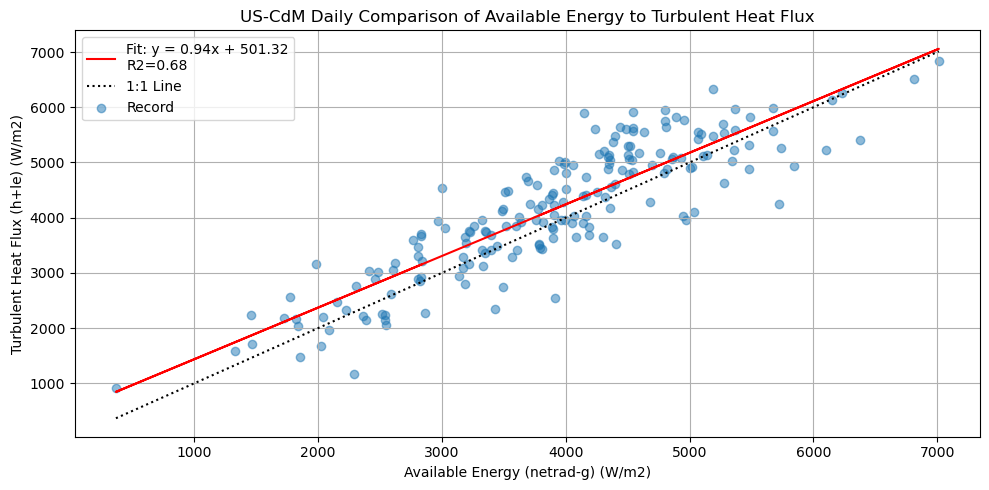

In [12]:
%matplotlib inline

plt.figure()
edplot.ols_plot(x = daily_clean['netrad_g'],
          y = daily_clean['h_le'],
          xlabel='Available Energy (netrad-g) (W/m2)', 
          ylabel='Turbulent Heat Flux (h+le) (W/m2)', 
          title=f'{stationid} Daily Comparison of Available Energy to Turbulent Heat Flux')  
plt.tight_layout()  
plt.savefig(f'closureols_daily_{stationid}.png')
plt.show()
plt.close() 


# Monthly Data

In [ ]:
clean_eddy['netrad_g'] = clean_eddy['netrad'] - clean_eddy['g']
clean_eddy['h_le'] = clean_eddy['h'] + clean_eddy['le']

regression_results = []

for month in clean_eddy.index.month.unique():
    month_data = clean_eddy[clean_eddy.index.month == month]
    x_month = month_data['netrad_g']
    y_month = month_data['h_le']
    slope, intercept, r_value, p_value, std_err = linregress(x_month, y_month)
    regression_results.append({
        'Month': month,
        'Slope': slope,
        'Intercept': intercept,
        'R-squared': r_value**2, # R-squared is the square of the R-value
        'P-value': p_value,
        'Std Error': std_err
    })

results_df = pd.DataFrame(regression_results)
print(round(results_df, 2))

In [ ]:
gs_monthly = clean_eddy.resample('ME').agg({
    'et':'sum',
    'p': 'sum',
    'le': 'mean',
    'h': 'mean',
    'netrad': 'mean',
    'sw_in': 'mean',
    'g': 'mean',
    'ws': 'mean',
    'ws_max': 'mean',
    'ta_1_1_1': 'mean',
    'stationid':'count',
})

print(pd.crosstab(gs_monthly.stationid, gs_monthly.index.month))
monthly_clean = gs_monthly.copy()

monthly_clean['netrad_g'] = monthly_clean['netrad']-monthly_clean['g']
monthly_clean['h_le'] = monthly_clean['h']+monthly_clean['le']
monthly_clean['closure'] = (monthly_clean['le']+monthly_clean['h'])/(monthly_clean['netrad']-monthly_clean['g'])

In [ ]:
print(f'Monthly Closure Values from {start_date} to {end_date}')
round(monthly_clean['closure'], 2)

In [ ]:
%matplotlib inline

plt.figure()
edplot.ols_plot(x = monthly_clean['netrad_g'],
          y = monthly_clean['h_le'],
          xlabel='Available Energy (netrad-g) (W/m2)', 
          ylabel='Turbulent Heat Flux (h+le) (W/m2)', 
          title=f'{stationid} Monthly Comparison of Available Energy to Turbulent Heat Flux')  
plt.tight_layout()  
plt.savefig(f'closureols_monthly_{stationid}.png')
plt.show()
plt.close() 

# Growing Season Results

In [ ]:
gs_annual = clean_eddy.resample('YE').agg({
    'et':'sum',
    'p': 'sum',
    'le': 'mean',
    'h': 'mean',
    'netrad': 'mean',
    'sw_in': 'mean',
    'g': 'mean',
    'ws': 'mean',
    'ws_max': 'mean',
    'ta_1_1_1': 'mean',
    'stationid':'count',
})

gs_annually_clean = gs_annual.copy()

gs_annual['closure'] = (gs_annual['le']+gs_annual['h'])/(gs_annual['netrad']-gs_annual['g'])

print(f"Growing season closure from {start_date} to {end_date} is {round(gs_annual['closure'].iloc[0], 2)}")